In [26]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import gc
import copy
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime


from keras.layers import Dense, Input, Activation
from keras.layers import BatchNormalization,Add,Dropout
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K

In [4]:
csv_file_folder =  '../../data/input'
file_folder =  '../../data/feature'

In [5]:
submission = pd.read_csv(f'{csv_file_folder}/sample_submission.csv')

In [6]:
def create_nn_model(input_shape):
    dropout = .2
    inp = Input(shape=(input_shape,))
    x = Dense(2048, activation="relu")(inp)
    x = BatchNormalization()(x)
#     x = Dropout(dropout)(x)
    for i in range(2):
        x = Dense(1024, activation="relu")(x)
        x = BatchNormalization()(x)
#         x = Dropout(dropout)(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
#     x = Dropout(dropout)(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
#     x = Dropout(dropout)(x)
    out = Dense(1, activation="linear")(x)  
   # out1 = Dense(2, activation="linear")(x)#mulliken charge 2
   # out2 = Dense(6, activation="linear")(x)#tensor 6(xx,yy,zz)
   # out3 = Dense(12, activation="linear")(x)#tensor 12(others) 
   # out4 = Dense(1, activation="linear")(x)#scalar_coupling_constant 
    #model = Model(inputs=inp, outputs=[out,out1,out2,out3,out4])
    model = Model(inputs=inp, outputs=[out])
    return model

In [7]:
def plot_history(history, label):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

In [8]:
# Set up GPU preferences
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.Session(config=config) 
K.set_session(sess)

In [9]:

type_columns = [['tertiary_angle_0', 'inv_dist1R', 'd_4_3', 'yukawa_H.y', 'mulliken_atom_0', 'dist_to_type_mean', 'dist_O_0_x', 'atom_1_n_bonds', 'dist_to_type_1_mean', 'atom_1_bond_lengths_mean', 'dist_xyz', 'dist_C_0_y', 'd_3_2', 'atom_index_1_ hybridization', 'atom_index_1_cycle_size_mean', 'dist_O_0_y', 'eem_1', 'inv_distPE', 'd_4_2', 'inv_distPR', 'dist_no_bond_min_y', 'dist_H_2_x', 'dist_H_1_x', 'tertiary_distance_2', 'dist_C_3_x', 'dist_O_1_x', 'atom_1_bond_lengths_std', 'dist_C_2_y', 'dist_C_2_x', 'mulliken_atom_1', 'cos_center1', 'dist_O_1_y', 'tertiary_angle_3', 'dist_H_2_y', 'dist_N_0_y', 'dist_C_1_y', 'inv_dist1E', 'distance_y', 'tertiary_angle_2', 'dist_N_0_x', 'd_2_1', 'molecule_atom_index_0_dist_max_div', 'adC1', 'adN1', 'd_4_0', 'dist_C_3_y', 'atom_3', 'distC0', 'tertiary_distance_4', 'tertiary_angle_5', 'd_5_1', 'molecule_atom_index_1_dist_min_diff', 'dist_C_4_y', 'dist_H_0_y', 'cos_f0', 'd_5_0', 'tertiary_distance_3', 'd_5_2', 'tertiary_atom_1', 'dist_C_4_x', 'cos_c0_f0', 'atom_index_0_sv_3', 'rc_C', 'cos_f1', 'tertiary_angle_8', 'dist_O_2_y', 'max_molecule_atom_1_dist_xyz', 'dist_F_0_y', 'atom_index_1_ aromatic', 'tertiary_angle_26', 'type_0'],
['dist_H_0_y', 'd_3_2', 'dist_C_0_y', 'atom_index_1_ aromatic', 'atom_1_bond_lengths_mean', 'bond_atom', 'inv_dist1R', 'd_3_1', 'mulliken_atom_0', 'dist_H_0_x', 'dist_O_0_y', 'dist_C_1_x', 'tertiary_angle_0', 'dist_C_1_y', 'vander_C.y', 'dist_H_1_y', 'mulliken_atom_1', 'inv_dist0R', 'd_1_0', 'tertiary_distance_0', 'tertiary_angle_2', 'atom_index_1_explicit_valence', 'dist_N_0_y', 'inv_distPR', 'dist_C_2_x', 'vander_H.x', 'd_4_2', 'atom_index_0_eigv_max', 'tertiary_distance_2', 'dist_H_1_x', 'dist_N_1_x', 'dist_C_3_x', 'cos_f0', 'atom_index_1_sv_2', 'max_molecule_atom_0_dist_xyz', 'd_2_1'],
['tertiary_atom_0', 'inv_dist0', 'dist_no_bond_min_x', 'atom_index_1_ hybridization', 'tertiary_angle_0', 'tertiary_angle_1', 'dist_O_0_x', 'cos_c0', 'd_5_2', 'tertiary_atom_1', 'cos_f0', 'dist_H_0_x', 'd_3_1', 'atom_index_1_degree', 'dist_C_0_y', 'adC2', 'dist_C_3_x', 'vander_O.y', 'mulliken_atom_1', 'atom_7', 'tertiary_angle_2', 'd_2_1', 'atom_3', 'd_5_1', 'd_6_2', 'd_4_1', 'tertiary_atom_2', 'molecule_atom_index_1_dist_min_diff', 'd_4_2', 'dist_C_2_x', 'cos_c0_f0', 'd_6_0', 'dist_O_0_y', 'd_4_3', 'd_3_0', 'd_7_0', 'd_3_2', 'inv_dist0R', 'atom_8', 'dist_C_1_x', 'd_6_1', 'd_2_0', 'd_8_1', 'mulliken_atom_0', 'dist_N_0_x', 'atom_4', 'tertiary_distance_2', 'd_7_2', 'dist_C_0_x', 'atom_1_bond_lengths_mean', 'dist_C_1_y', 'bond_atom', 'd_7_1', 'd_4_0', 'distC0', 'atom_index_1_cycle_size_mean', 'cos_c0_c1', 'tertiary_angle_3', 'dist_O_1_x', 'atom_index_1_n_cycle', 'max_molecule_atom_0_dist_xyz', 'molecule_atom_index_0_dist_max_div', 'atom_5', 'gap', 'cos_c1', 'dist_N_0_y', 'd_6_3', 'dist_C_3_y', 'inv_distP', 'dist_C_4_y'],
['cos_c0', 'd_4_3', 'cos_c0_c1', 'molecule_atom_index_0_dist_min_diff', 'tertiary_atom_1', 'd_3_2', 'd_1_0', 'dist_H_0_y', 'mulliken_atom_0', 'mulliken_atom_1', 'dist_N_0_x', 'link0', 'tertiary_atom_2', 'dist_C_1_y', 'dist_C_1_x', 'cos_f0', 'dist_C_0_y', 'cos_f1', 'd_3_1', 'tertiary_distance_1', 'dist_O_0_y', 'cos_f0_f1', 'adC1', 'd_5_3', 'inv_distP', 'edge_4', 'd_6_2', 'dist_N_0_y', 'tertiary_distance_2', 'dist_O_0_x', 'cos_c1_f1', 'd_3_0', 'd_5_2', 'dist_C_0_x', 'adN1', 'cos_c0_f0', 'd_4_1', 'max_distance_y', 'dist_C_2_y', 'atom_5', 'adC3', 'dist_to_type_1_mean', 'vander_H.x', 'dist_C_3_y', 'dist_H_3_x', 'molecule_atom_index_0_dist_max_div', 'atom_7', 'dist_C_3_x', 'd_5_1', 'dist_H_3_y', 'atom_index_0_eigv_max', 'atom_6', 'dist_H_2_x', 'atom_index_1_sv_0', 'molecule_atom_index_1_dist_std_div', 'link1'],
['d_3_1', 'dist_H_1_x', 'd_5_0', 'd_4_0', 'yukawa_H.x', 'inv_dist0', 'd_6_0', 'd_4_1', 'cos_c0', 'atom_3', 'dist_C_0_y', 'molecule_atom_index_0_dist_std_div', 'cos_c0_c1', 'd_4_2', 'min_molecule_atom_0_dist_xyz', 'sd_molecule_atom_0_dist_xyz', 'd_2_1', 'adC2', 'd_3_0', 'dist_C_1_y', 'd_4_3', 'dist_H_0_x', 'vander_C.x', 'd_5_3', 'dist_H_1_y', 'tertiary_distance_3', 'd_2_0', 'dist_O_0_x', 'd_5_1', 'dist_O_0_y', 'adC3', 'inv_dist0R', 'dist_C_3_y', 'atom_index_1_ hybridization', 'cos_f0', 'dist_C_2_x', 'd_5_2', 'd_6_1', 'dist_C_0_x', 'atom_1_bond_lengths_min', 'mulliken_atom_1', 'distance_farthest_0', 'tertiary_distance_1', 'min_molecule_atom_1_dist_xyz', 'yukawa_O.y', 'atom_0_bond_lengths_max'],
['tertiary_angle_0', 'd_2_1', 'cos_c0', 'atom_1_bond_lengths_mean', 'd_3_1', 'd_2_0', 'tertiary_distance_1', 'd_3_2', 'tertiary_angle_1', 'cos_f0', 'tertiary_distance_2', 'dist_C_0_x', 'dist_H_0_x', 'dist_C_2_x', 'dist_O_0_y', 'd_4_1', 'd_4_3', 'atom_index_1_cycle_size_mean', 'molecule_atom_index_0_dist_min_diff', 'tertiary_atom_2', 'atom_4', 'cos_c0_f0', 'tertiary_distance_3', 'd_3_0', 'dist_median_bond_y', 'd_5_2', 'adC3', 'atom_5', 'dist_H_1_x', 'molecule_atom_index_0_dist_min_div', 'gap', 'molecule_atom_index_1_dist_min_div', 'dist_O_0_x', 'cos_c1', 'dist_C_0_y', 'd_5_1', 'dist_N_0_y', 'dist_C_3_y', 'dist_no_bond_min_y', 'd_4_0', 'dist_N_0_x', 'd_4_2', 'max_molecule_atom_0_dist_xyz', 'cos_c0_c1', 'adC2', 'atom_index_1_n_cycle', 'd_5_0', 'd_6_1', 'dist_C_4_y', 'dist_O_1_y', 'd_7_2', 'tertiary_angle_2', 'd_6_2', 'mulliken_atom_1', 'atom_6', 'd_7_3', 'dist_O_1_x'],
['cos_c0_c1', 'atom_4', 'atom_5', 'molecule_atom_index_0_dist_min_diff', 'cos_c1', 'max_molecule_atom_1_dist_xyz', 'dist_to_type_std', 'd_3_2', 'cos_c0', 'dist_O_0_x', 'd_4_3', 'atom_6', 'dist_O_0_y', 'tertiary_atom_1', 'dist_C_2_y', 'd_4_2', 'dist_C_1_y', 'atom_7', 'tertiary_angle_1', 'dist_H_0_y', 'dist_no_bond_min_y', 'distance_c1', 'dist_C_2_x', 'linkM0', 'd_6_2', 'dist_C_0_y', 'd_5_2', 'd_7_2', 'dist_C_3_y', 'd_6_0', 'dihedral', 'max_molecule_atom_0_dist_xyz', 'd_7_3', 'd_6_1', 'dist_H_1_y', 'tertiary_atom_2', 'd_4_0', 'tertiary_atom_0', 'tertiary_angle_3', 'dist_C_0_x', 'dist_to_type_0_mean', 'dist_N_0_y', 'd_4_1', 'cos_c1_f1', 'cos_f0', 'dist_xyz', 'adC2', 'd_5_3', 'cos_f0_f1', 'gap', 'd_7_0', 'cos_f1', 'tertiary_distance_1', 'molecule_atom_index_0_dist_max_diff', 'd_2_1'],
['cos_c0', 'tertiary_distance_1', 'cos_c1', 'd_3_2', 'tertiary_angle_1', 'tertiary_angle_0', 'atom_1_n_bonds', 'tertiary_distance_2', 'd_2_1', 'tertiary_angle_2', 'd_4_0', 'molecule_atom_index_0_dist_min_div', 'd_2_0', 'dist_H_0_x', 'd_3_1', 'cos_c0_c1', 'mulliken_atom_1', 'd_8_3', 'd_4_1', 'dist_C_0_y', 'd_3_0', 'atom_index_1_cycle_size_mean', 'dist_C_1_x', 'dist_C_2_x', 'adC2', 'adC1', 'atom_1_bond_lengths_std', 'atom_index_1_n_cycle', 'd_4_2', 'cos_f0', 'd_5_2', 'dist_to_type_0_mean', 'dist_O_0_x', 'molecule_atom_index_0_dist_std_diff', 'd_5_1', 'tertiary_angle_3', 'd_6_2', 'd_7_3']]

In [10]:
unique_cols = []
for cols in type_columns:
    unique_cols += cols
unique_cols = list(set(unique_cols))

In [11]:
len(unique_cols)

153

In [12]:
plus_cols = pd.read_pickle(f'{file_folder}/df_train2_plus.gzde', compression='gzip').columns.tolist()

In [13]:
unique_cols_plus = [col for col in unique_cols if col in plus_cols]

In [14]:
unique_cols_data2 = list(set(unique_cols) - set(unique_cols_plus))

In [15]:
len(unique_cols_data2), len(unique_cols_plus)

(105, 48)

In [16]:
df_train2 = pd.read_pickle(f'{file_folder}/df_train2.gzde', compression='gzip')[['index', 'type', 'group', 'scalar_coupling_constant', 'fc', 'sd','pso','dso']+unique_cols_data2]
df_train2_plus = pd.read_pickle(f'{file_folder}/df_train2_plus.gzde', compression='gzip')[['id']+unique_cols_plus]
df_train2_plus = df_train2_plus.rename(columns={'id':'index'})
df_train2 = pd.merge(df_train2, df_train2_plus, how='left', on='index')
df_train2 = df_train2.fillna(0)

df_test2 = pd.read_pickle(f'{file_folder}/df_test2.gzde', compression='gzip')[['index', 'type', 'group']+unique_cols_data2]
df_test2_plus = pd.read_pickle(f'{file_folder}/df_test2_plus.gzde', compression='gzip')[['id']+unique_cols_plus]
df_test2_plus = df_test2_plus.rename(columns={'id':'index'})
df_test2 = pd.merge(df_test2, df_test2_plus, how='left', on='index')
df_test2 = df_test2.fillna(0)

In [17]:
oof_path = '../select_features'

In [22]:
# df_train = pd.DataFrame()
# df_test = pd.DataFrame()

# for f in [f for f in os.listdir(oof_path) if f.startswith('oof')][:]:
    
#     if 'train' in f:
#         df_i = pd.read_pickle(f'{oof_path}/{f}', compression='gzip')
#         df_train[f'{f}'.replace('_train', '')] = df_i.predict
#         if 'index' not in df_train.columns:
#             df_train['index'] = df_i['index']
        
#     if 'test' in f:
#         df_i = pd.read_pickle(f'{oof_path}/{f}', compression='gzip')
#         df_test[f'{f}'.replace('_test', '')] = df_i.drop(columns=['index']).mean(axis=1)
#         if 'index' not in df_test.columns:
#             df_test['index'] = df_i['index']

In [20]:
# df_train = pd.merge(df_train2[['index', 'type', 'group', 'scalar_coupling_constant', 'fc', 'sd','pso','dso']+unique_cols], df_train, how='left', on='index')
# df_train['y'] = df_train2['scalar_coupling_constant']
# df_test = pd.merge(df_test2[['index', 'type', 'group']+unique_cols], df_test, how='left', on='index')

In [21]:
df_train = df_train2[['index', 'type', 'group', 'scalar_coupling_constant', 'fc', 'sd','pso','dso']+unique_cols]
df_test = df_test2[['index', 'type', 'group']+unique_cols]

In [22]:
type_list = df_train.type.unique().tolist()
type_list

[0, 3, 1, 4, 2, 6, 5, 7]

In [24]:
retrain =True
cv_score=[]
cv_score_total=0
epoch_n = 1000
verbose = 0
batch_size = 2048

Training 0 out of [0, 3, 1, 4, 2, 6, 5, 7] 


Epoch 00154: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00215: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00286: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00325: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00335: early stopping


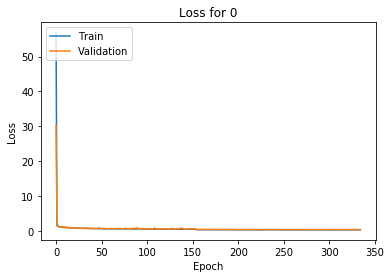

0-0 -0.7556487689046044

Epoch 00141: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00246: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00318: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00382: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00392: early stopping


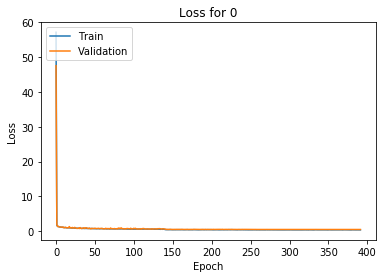

0-1 -0.7603820729438441

Epoch 00126: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00261: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00314: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00324: early stopping


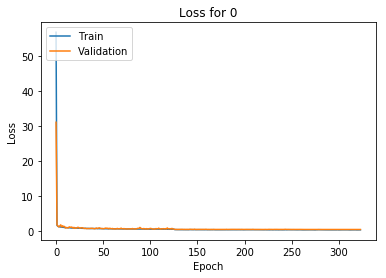

0-2 -0.7445672675813626

Epoch 00146: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00226: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00276: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00286: early stopping


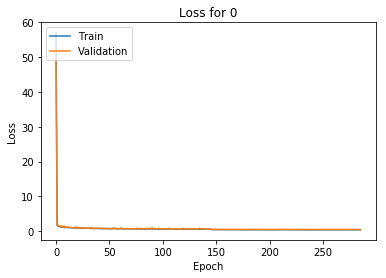

0-3 -0.7546029259491598

Epoch 00179: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00259: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00312: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00322: early stopping


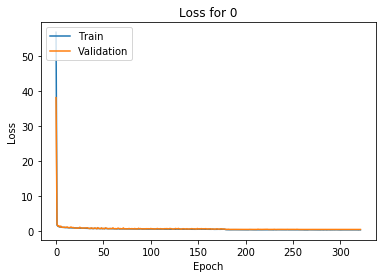

0-4 -0.7443814094829971

Epoch 00110: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00195: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00266: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00306: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00316: early stopping


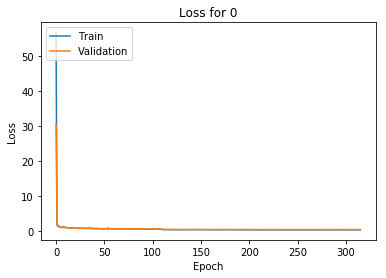

0-5 -0.7465132045669548

Epoch 00145: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00214: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00267: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00277: early stopping


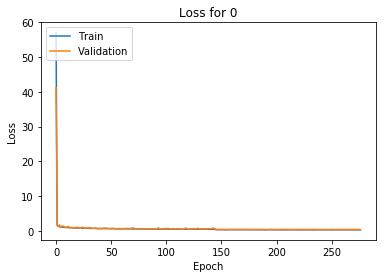

0-6 -0.7568466539879637

Epoch 00108: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00231: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00293: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00331: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00341: early stopping


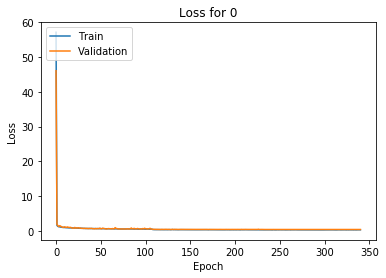

0-7 -0.745367268747327
Training 3 out of [0, 3, 1, 4, 2, 6, 5, 7] 


Epoch 00179: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00265: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00311: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00321: early stopping


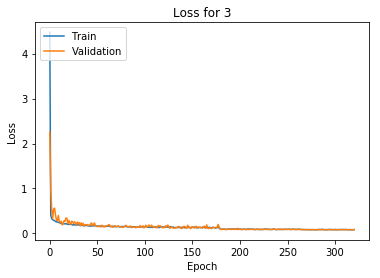

3-0 -2.494866546087776

Epoch 00149: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00229: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00284: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00317: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00365: early stopping


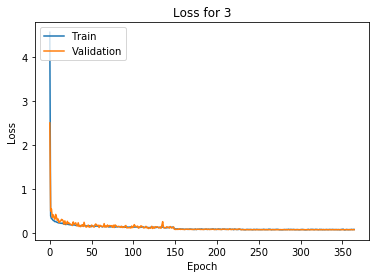

3-1 -2.5015770080606723

Epoch 00113: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00191: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00268: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00330: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00340: early stopping


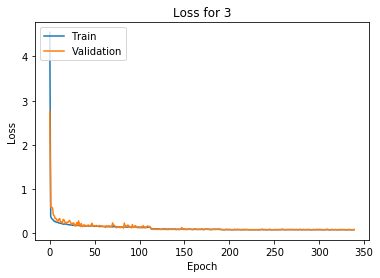

3-2 -2.486368967915282

Epoch 00143: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00231: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00282: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00292: early stopping


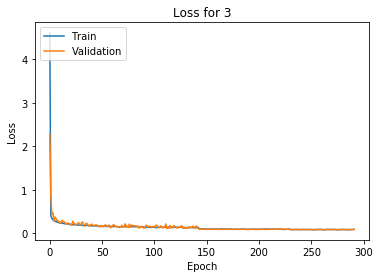

3-3 -2.4712233710830778

Epoch 00107: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00217: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00264: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00274: early stopping


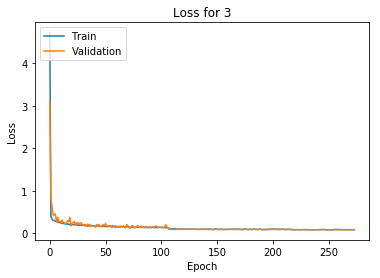

3-4 -2.4812164953675975

Epoch 00130: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00217: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00311: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00360: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00370: early stopping


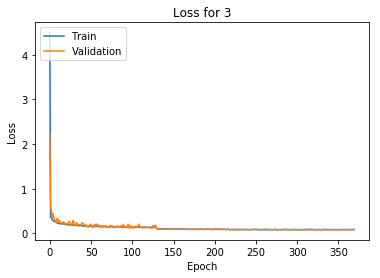

3-5 -2.4870027500869587

Epoch 00119: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00212: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00260: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00306: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00316: early stopping


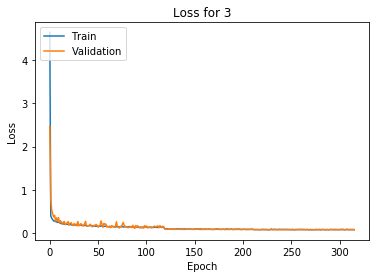

3-6 -2.497088752498617

Epoch 00191: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00264: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00296: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00344: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00354: early stopping


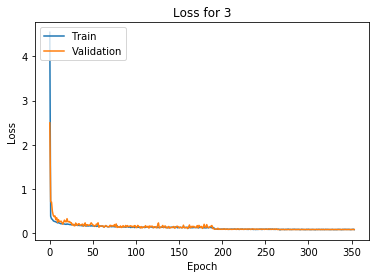

3-7 -2.488146827113229
Training 1 out of [0, 3, 1, 4, 2, 6, 5, 7] 


Epoch 00145: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00194: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00285: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00333: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00343: early stopping


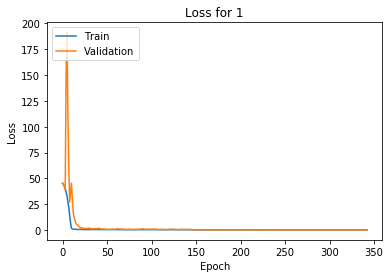

1-0 -1.342268499866041

Epoch 00210: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00272: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00374: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00413: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00423: early stopping


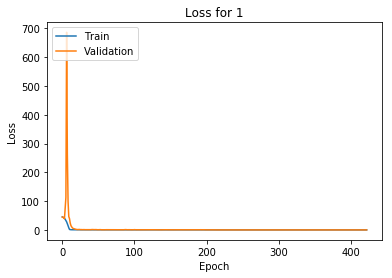

1-1 -1.4160479806309716

Epoch 00079: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00170: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00222: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00301: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00311: early stopping


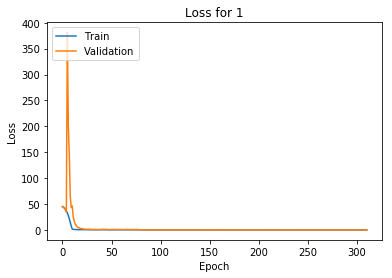

1-2 -1.3313764032441848

Epoch 00101: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00199: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00335: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00373: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00383: early stopping


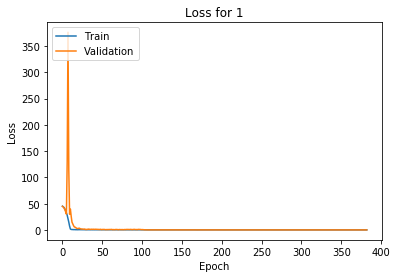

1-3 -1.3610734726872613

Epoch 00084: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00254: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00308: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00351: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00361: early stopping


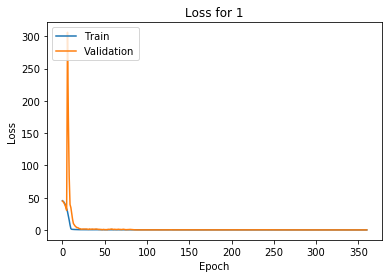

1-4 -1.3635115521088934

Epoch 00149: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00190: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00254: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00314: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00357: early stopping


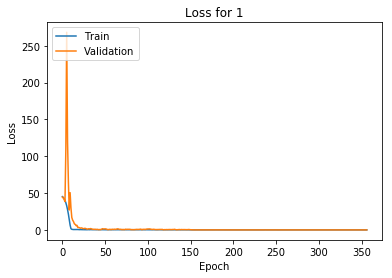

1-5 -1.3087665666475365

Epoch 00079: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00205: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00361: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00423: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00433: early stopping


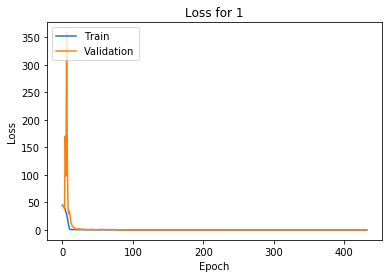

1-6 -1.3903432709857864

Epoch 00138: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00177: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00262: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00302: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00350: early stopping


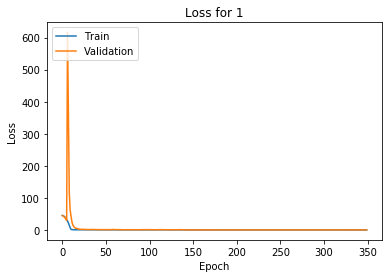

1-7 -1.3502050319016141
Training 4 out of [0, 3, 1, 4, 2, 6, 5, 7] 


Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00187: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00243: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00291: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00301: early stopping


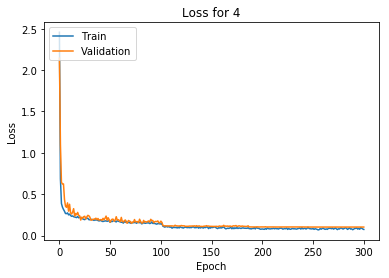

4-0 -2.266434335255184

Epoch 00224: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00362: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00406: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00460: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00470: early stopping


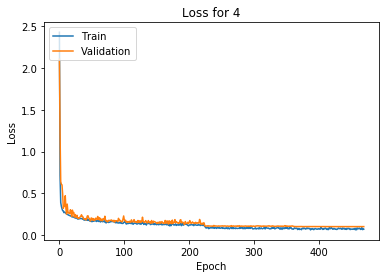

4-1 -2.300839451495034

Epoch 00291: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00358: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00425: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00435: early stopping


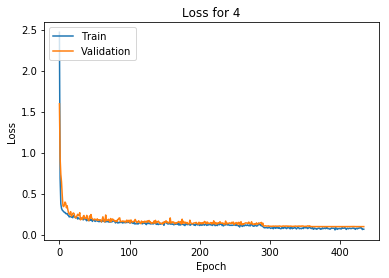

4-2 -2.3297271082317303

Epoch 00182: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00328: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00399: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00409: early stopping


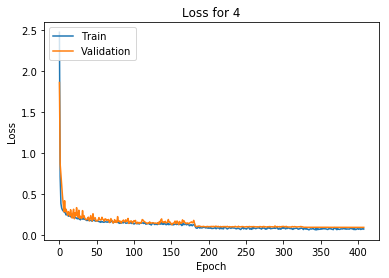

4-3 -2.3428448811642464

Epoch 00112: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00277: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00367: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00404: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00414: early stopping


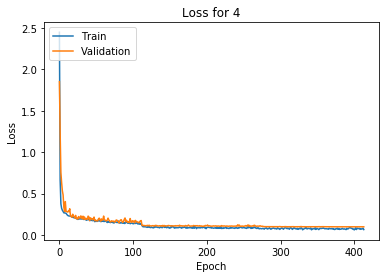

4-4 -2.3080862315347397

Epoch 00086: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00185: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00277: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00340: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00350: early stopping


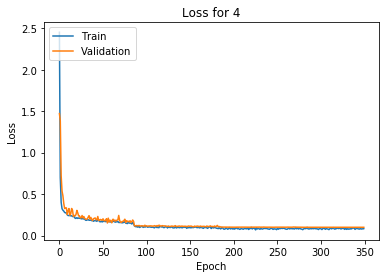

4-5 -2.309454737173677

Epoch 00270: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00405: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00464: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00474: early stopping


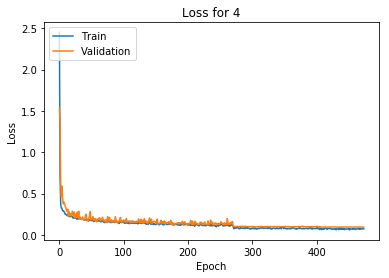

4-6 -2.336857568322429

Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00304: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00374: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00409: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00419: early stopping


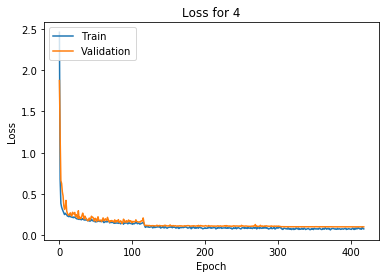

4-7 -2.305670115912003
Training 2 out of [0, 3, 1, 4, 2, 6, 5, 7] 


Epoch 00231: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00280: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00318: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00328: early stopping


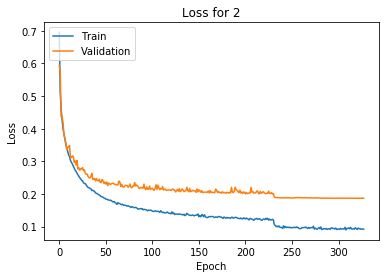

2-0 -1.6782367465961765

Epoch 00238: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00309: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00356: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00366: early stopping


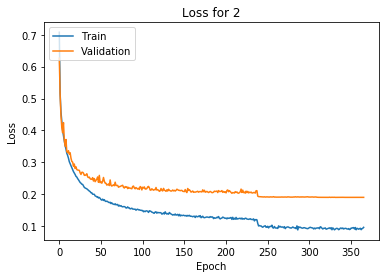

2-1 -1.6600545200659416

Epoch 00296: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00344: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00391: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00401: early stopping


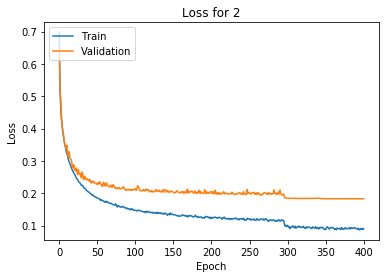

2-2 -1.6980936711417078

Epoch 00315: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00375: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00426: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00436: early stopping


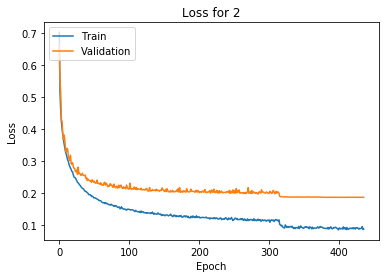

2-3 -1.6768094384967906

Epoch 00289: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00349: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00393: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00403: early stopping


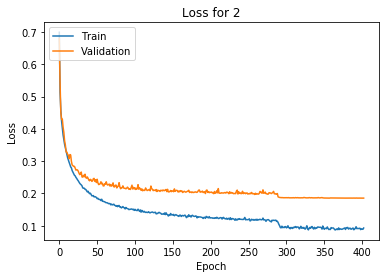

2-4 -1.6845820285832946

Epoch 00233: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00301: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00364: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00374: early stopping


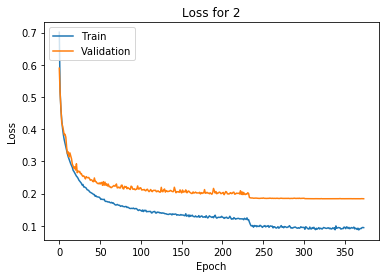

2-5 -1.694889286918261

Epoch 00202: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00254: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00307: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00317: early stopping


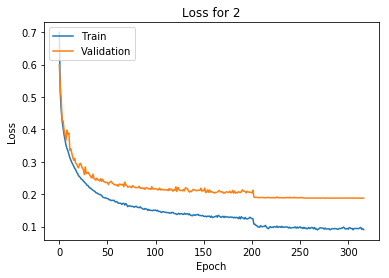

2-6 -1.6738192347702354

Epoch 00223: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00279: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00322: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00332: early stopping


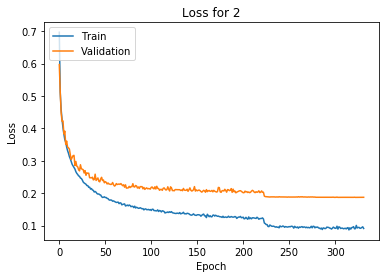

2-7 -1.6752393656212985
Training 6 out of [0, 3, 1, 4, 2, 6, 5, 7] 


Epoch 00241: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00290: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00354: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00364: early stopping


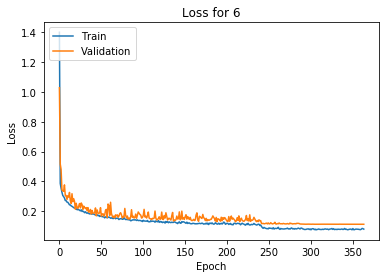

6-0 -2.1819526453679643

Epoch 00176: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00216: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00251: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00286: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00296: early stopping


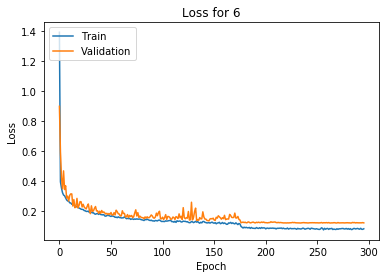

6-1 -2.1092805908902887

Epoch 00175: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00270: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00309: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00347: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00357: early stopping


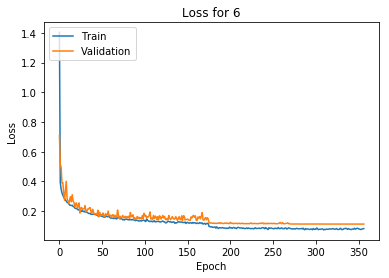

6-2 -2.1789506217433985

Epoch 00247: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00315: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00353: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00363: early stopping


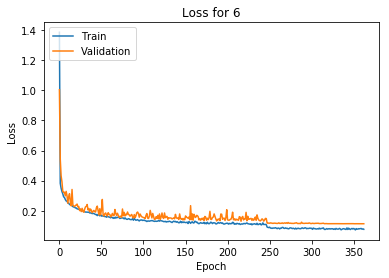

6-3 -2.1749550185997

Epoch 00130: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00261: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00316: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00326: early stopping


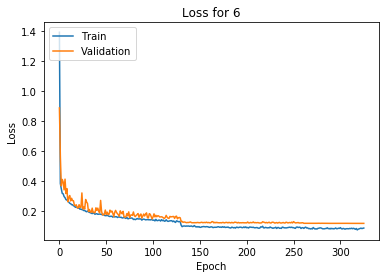

6-4 -2.159409301187525

Epoch 00234: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00273: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00315: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00349: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00359: early stopping


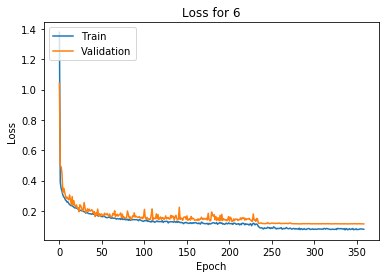

6-5 -2.1768718344924296

Epoch 00194: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00229: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00285: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00295: early stopping


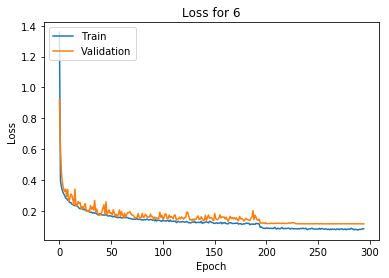

6-6 -2.157838389483302

Epoch 00242: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00300: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00349: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00359: early stopping


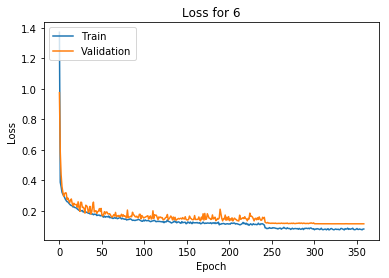

6-7 -2.173540477575772
Training 5 out of [0, 3, 1, 4, 2, 6, 5, 7] 


Epoch 00250: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00304: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00349: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00359: early stopping


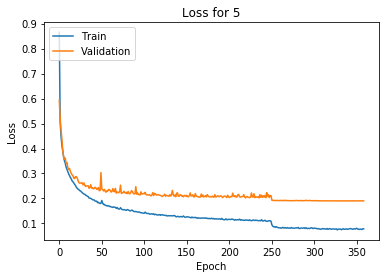

5-0 -1.6597231881498462

Epoch 00219: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00282: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00321: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00331: early stopping


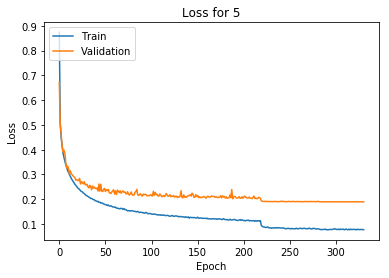

5-1 -1.662475486132981

Epoch 00241: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00319: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00369: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00379: early stopping


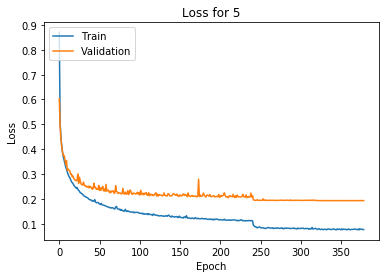

5-2 -1.646236293408134

Epoch 00211: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00246: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00283: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00293: early stopping


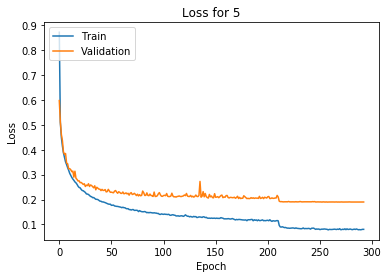

5-3 -1.6618059263758245

Epoch 00284: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00339: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00374: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00384: early stopping


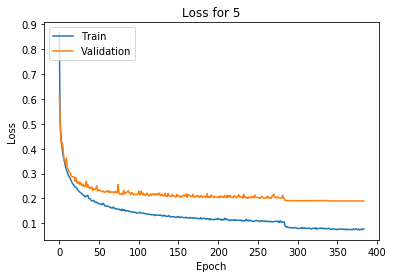

5-4 -1.659962346987066

Epoch 00259: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00304: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00371: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00381: early stopping


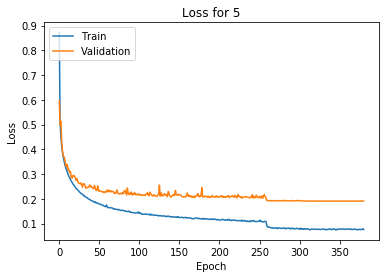

5-5 -1.6567147104868518

Epoch 00232: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00278: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00321: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00331: early stopping


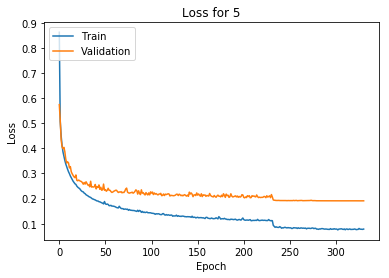

5-6 -1.6552574582751582

Epoch 00366: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00421: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00459: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00469: early stopping


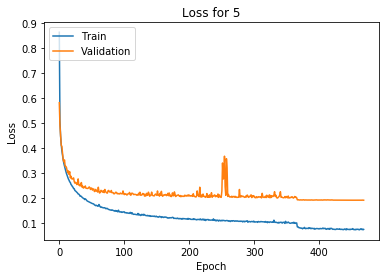

5-7 -1.65670587900383
Training 7 out of [0, 3, 1, 4, 2, 6, 5, 7] 


Epoch 00248: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00317: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00356: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00366: early stopping


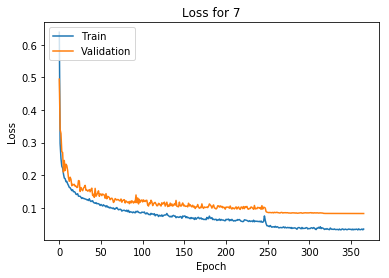

7-0 -2.4957916082957343

Epoch 00239: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00297: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00334: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00372: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00382: early stopping


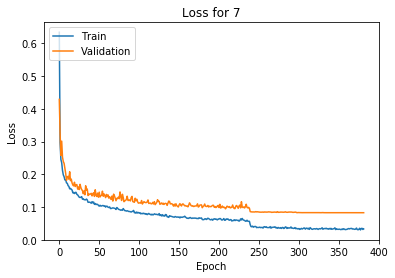

7-1 -2.487627440331423

Epoch 00148: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00218: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00285: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00295: early stopping


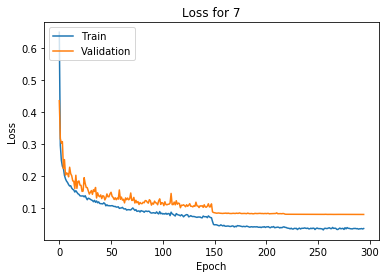

7-2 -2.508586111787455

Epoch 00223: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00284: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00335: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00345: early stopping


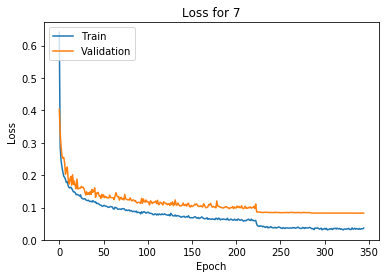

7-3 -2.486892750556471

Epoch 00226: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00283: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00349: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00380: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00390: early stopping


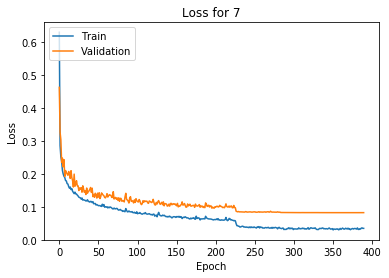

7-4 -2.4859092290179734

Epoch 00294: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00357: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00415: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00425: early stopping


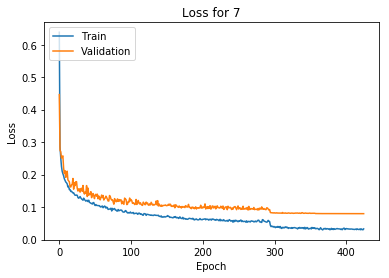

7-5 -2.527806165351272

Epoch 00194: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00315: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00374: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00384: early stopping


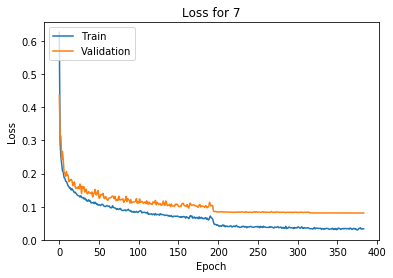

7-6 -2.5149668260027425

Epoch 00258: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00353: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00401: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00411: early stopping


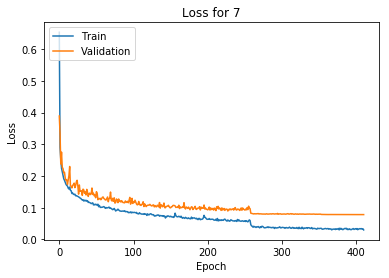

7-7 -2.5451021590196716


In [58]:


start_time=datetime.now()
# test_prediction=np.zeros(len(test_csv))
test_predict_list = {}


his = []
# Loop through each molecule type
for mol_type in type_list:

    model_name_wrt = ('molecule_model_%s.hdf5' % mol_type)
    print('Training %s' % mol_type, 'out of', type_list, '\n')
    
    df_train_i = df_train[df_train['type']==mol_type][type_columns[mol_type]]
    df_test_i = df_test[df_test['type']==mol_type][type_columns[mol_type]]
    
#     full = build_couple_dataframe(train_csv, structures_csv, mol_type, n_atoms=11)
#     full2 = build_couple_dataframe(test_csv, structures_csv, mol_type, n_atoms=11)
#     df_train_ = take_n_atoms(full, 11)
#     df_test_ = take_n_atoms(full2, 11)
#     df_train_  = df_train_.fillna(0)
#     df_test_  = df_test_.fillna(0)
    
#     # Standard Scaler from sklearn does seem to work better here than other Scalers
#     input_data=StandardScaler().fit_transform(pd.concat([df_train_.loc[:,input_features],df_test_.loc[:,input_features]]))   
#     #input_data=StandardScaler().fit_transform(df_train_.loc[:,input_features])
#     target_data=df_train_.loc[:,"scalar_coupling_constant"].values
    
    input_data=StandardScaler().fit_transform(pd.concat([df_train_i,  df_test_i]))
    X_train = input_data[:len(df_train_i),:]
    y_train =df_train[df_train['type']==mol_type]["fc"].values
    X_test = input_data[len(df_train_i):,:]
    group = df_train[df_train['type']==mol_type].group
    
    
    # Simple split to provide us a validation set to do our CV checks with
#     train_index, cv_index = train_test_split(np.arange(len(df_train_i)),random_state=111, test_size=0.2)

    group_kfold = GroupKFold(n_splits=8)
    for n_fold, (train_index, cv_index) in enumerate(group_kfold.split(X_train, y_train, group)):
        
        # Split all our input and targets by train and cv indexes
        train_target=y_train[train_index]
        cv_target=y_train[cv_index]
        train_input=X_train[train_index]
        cv_input=X_train[cv_index]
    
        # Build the Neural Net
        nn_model=create_nn_model(train_input.shape[1])
    
        # If retrain==False, then we load a previous saved model as a starting point.
        if not retrain:
            nn_model = load_model(model_name_rd)

        nn_model.compile(loss='mae', optimizer=Adam())#, metrics=[auc])

        # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
        es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=40,verbose=1, mode='auto', restore_best_weights=True)
        # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
        rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=30, min_lr=1e-6, mode='auto', verbose=1)
        # Save the best value of the model for future use
        sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True, period=1)
        history = nn_model.fit(train_input,[train_target], 
                validation_data=(cv_input,[cv_target]), 
                callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)

        cv_predict=nn_model.predict(cv_input)
        plot_history(history, mol_type)
        accuracy=np.mean(np.abs(cv_target-cv_predict[:,0]))
        print(f'{mol_type}-{n_fold}', np.log(accuracy))
        cv_score.append(np.log(accuracy))
        cv_score_total+=np.log(accuracy)

        # Predict on the test data set using our trained model
        test_predict=nn_model.predict(X_test)

        # for each molecule type we'll grab the predicted values
#         test_predict_list[mol_type] = test_predict
    #     test_csv[test_csv["type"]==mol_type]=test_predict[:,0]
    
        his.append({'type':mol_type, 'nfold':n_fold, 'cv_index':cv_index, 'test_predict':test_predict, 'cv_predict':cv_predict})
        K.clear_session()
#     break
#     break

# cv_score_total/=len(mol_types)

In [59]:
df_his = pd.DataFrame(his)

In [60]:
df_his.head()

,cv_index,cv_predict,nfold,test_predict,type
0,"[0, 1, 2, 3, 21, 22, 23, 24, 62, 63, 75, 76, 7...","[[46.49276], [46.01351], [45.726864], [45.5376...",0,"[[139.18507], [138.71072], [87.772255], [87.82...",0
1,"[49, 50, 51, 91, 92, 93, 94, 95, 96, 123, 124,...","[[79.42059], [87.82109], [81.507256], [97.6582...",1,"[[165.17276], [166.3898], [83.740395], [83.627...",0
2,"[34, 35, 36, 37, 38, 39, 40, 41, 42, 69, 70, 7...","[[82.94989], [83.00618], [77.33949], [85.5906]...",2,"[[155.69196], [154.44757], [85.39551], [85.396...",0
3,"[18, 19, 20, 86, 87, 136, 137, 138, 139, 140, ...","[[98.31371], [98.154915], [98.47818], [92.2050...",3,"[[170.64955], [171.61879], [88.52466], [88.460...",0
4,"[11, 12, 13, 25, 26, 27, 28, 29, 30, 31, 32, 3...","[[87.528595], [87.52977], [89.10669], [118.057...",4,"[[169.43327], [163.38889], [86.96536], [87.061...",0


In [61]:
df_his.to_pickle('mpl_cf_df_his', compression='gzip')

In [52]:
df_submission = pd.DataFrame()

for c, g in df_his.groupby(by='type'):
    df_test_i = df_test[df_test['type']==c]
    typ_i_test_pred = np.mean(np.array([g['test_predict'].values[i].reshape(-1) for i in np.arange(8)]), axis=0)
    df_test_i['pred'] = typ_i_test_pred
    df_submission = pd.concat([df_submission, df_test_i], axis=0)

In [55]:
df_submission = df_submission.reset_index(drop=True)
df_submission = df_submission[['index','pred']]
df_submission = df_submission.sort_values(by=['index'])
df_submission = df_submission.reset_index(drop=True)
df_submission = df_submission.rename(columns = {'index':'id','pred':'scalar_coupling_constant'})

In [56]:
df_submission.tail()

,id,scalar_coupling_constant
2505537,7163684,0.762915
2505538,7163685,3.211389
2505539,7163686,2.075879
2505540,7163687,4.755060
2505541,7163688,117.408432


In [62]:
valid_list = {0:-0.7333170030838179,
3:-2.4540746391087085,
1:-1.3474818937693096,
4:-2.2891633097476864,
2:-1.6972980093917749,
6:-2.137732236123424,
5:-1.6694864546861885,
7:-2.3854512965185575}

In [65]:
valid_mae = 0
for k, v in valid_list.items():
    valid_mae += np.exp(v)
valid_mae /= len(valid_list)

In [66]:
valid_mae

0.18862398603738667

In [49]:
df_submission = pd.DataFrame()
for k,v in test_predict_list.items():
    df_test_i = df_test[df_test['type']==k]
    df_test_i['pred'] = v
    df_submission = pd.concat([df_submission, df_test_i], axis=0)
df_submission = df_submission.reset_index(drop=True)
df_submission = df_submission[['index','pred']]
df_submission = df_submission.sort_values(by=['index'])
df_submission = df_submission.reset_index(drop=True)
df_submission = df_submission.rename(columns = {'index':'id','pred':'scalar_coupling_constant'})

In [57]:
idx='no_oof'
df_submission.to_csv('../../data/submission/submission_mpnn_{}.csv'.format(idx), index=False)
print(df_submission.shape)
df_submission.tail()


(2505542, 2)


,id,scalar_coupling_constant
2505537,7163684,0.762915
2505538,7163685,3.211389
2505539,7163686,2.075879
2505540,7163687,4.755060
2505541,7163688,117.408432
